# 04 - Model Evaluation

This notebook evaluates the final selected model:
Random Forest with optimized threshold.

We analyze:

- Precision-Recall Curve
- ROC Curve
- Confusion Matrix (Optimal Threshold)
- Feature Importance
- Operational Interpretation

This final evaluation demonstrates the model's performance
under extreme class imbalance.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report,
    average_precision_score,
    roc_auc_score
)


In [2]:
from pathlib import Path

processed_path = Path("../data/processed")

X_train = pd.read_csv(processed_path / "X_train.csv")
X_test = pd.read_csv(processed_path / "X_test.csv")
y_train = pd.read_csv(processed_path / "y_train.csv").values.ravel()
y_test = pd.read_csv(processed_path / "y_test.csv").values.ravel()


In [3]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_scores = rf.predict_proba(X_test)[:, 1]


## Precision-Recall Curve

The Precision-Recall curve is the most important evaluation metric
for extreme class imbalance problems.

It shows the trade-off between fraud detection (recall)
and false alarms (precision).


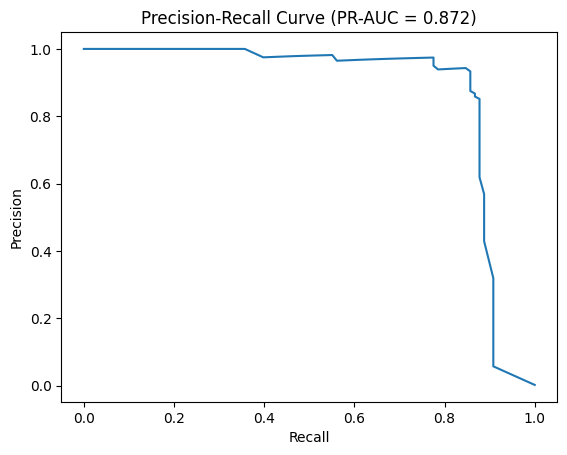

In [4]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

fig_path = Path("../reports/figures")
fig_path.mkdir(parents=True, exist_ok=True)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (PR-AUC = {pr_auc:.3f})")
plt.savefig(fig_path / "pr_curve.png", dpi=300)
plt.show()


## ROC Curve

Although ROC-AUC is commonly reported, 
it can be overly optimistic in highly imbalanced datasets.

We include it for completeness.


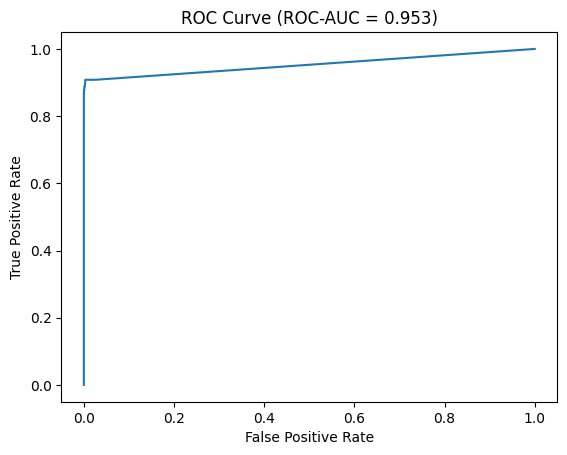

In [5]:
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (ROC-AUC = {roc_auc:.3f})")
plt.savefig(fig_path / "roc_curve.png", dpi=300)
plt.show()


In [6]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print("Best Threshold:", best_threshold)

Best Threshold: 0.46


In [7]:
y_pred_optimal = (y_scores >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_optimal))
print(confusion_matrix(y_test, y_pred_optimal))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.86      0.89        98

    accuracy                           1.00     56962
   macro avg       0.97      0.93      0.95     56962
weighted avg       1.00      1.00      1.00     56962

[[56858     6]
 [   14    84]]


## Feature Importance

Random Forest provides feature importance scores,
indicating which features contribute most to fraud detection.


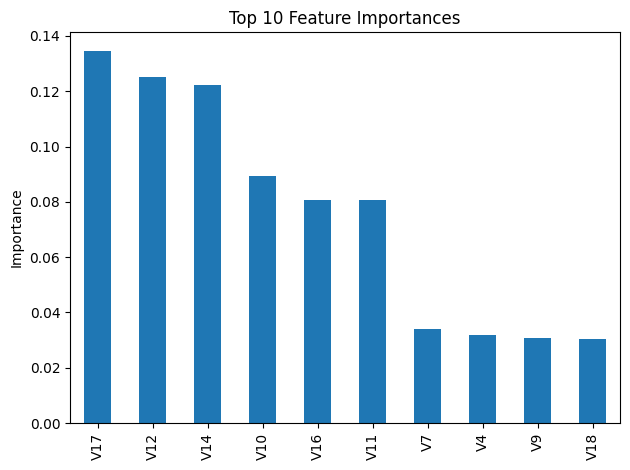

V17    0.134585
V12    0.125315
V14    0.122380
V10    0.089203
V16    0.080593
V11    0.080548
V7     0.033853
V4     0.031880
V9     0.030736
V18    0.030432
dtype: float64

In [ ]:
feature_importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

top_features = feature_importances.head(10)

plt.figure()
top_features.plot(kind="bar")
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig(fig_path / "feature_importance.png", dpi=300)
plt.show()


top_features

## Final Interpretation

- The Precision-Recall curve (PR-AUC ≈ 0.87) demonstrates strong fraud ranking capability under extreme class imbalance.
- Random Forest significantly outperformed Logistic Regression, indicating the presence of non-linear fraud patterns in the data.
- Threshold optimization improved the F1-score by increasing fraud recall while maintaining high precision.
- Feature importance analysis revealed that V17, V12, and V14 contribute most to fraud detection.

Overall, Random Forest with optimized threshold provides a robust balance between detecting fraudulent transactions and minimizing false alarms, making it the selected final model.
